In [1]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, \
BertForQuestionAnswering, DistilBertForTokenClassification, AutoTokenizer, AutoModel, AutoModelForTokenClassification, \
pipeline

from nlp import load_dataset, Dataset
import torch
import numpy as np
import pandas as pd


# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Quick Examples using the pipeline object in transformers

We can run some quick examples of fine-tuned models using the nlp module in the transformers package

In [2]:
# list of available pipelines here: https://huggingface.co/transformers/main_classes/pipelines.html
nlp = pipeline("question-answering")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForQuestionAnswering'>


In [3]:
context = "My friend Walker owns a Tarantula. I, Sinan, own a dog. Matt just got a cat!"

print(nlp(question="What kind of pet does Sinan have?", context=context))  # should be dog
print(nlp(question="What kind of pet does Matt have?", context=context))  # should be cat
print(nlp(question="What kind of pet does Walker have?", context=context))  # should be Tarantula

Ignored unknown kwarg option direction
{'score': 0.7949584126472473, 'start': 51, 'end': 54, 'answer': 'dog'}
Ignored unknown kwarg option direction
{'score': 0.7224206924438477, 'start': 72, 'end': 75, 'answer': 'cat'}
Ignored unknown kwarg option direction
{'score': 0.816719651222229, 'start': 24, 'end': 33, 'answer': 'Tarantula'}


In [4]:
# A sentiment analysis pipeline
nlp = pipeline("sentiment-analysis")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

print(nlp("My friend told me about this class and I love it so far! She was right."))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
[{'label': 'POSITIVE', 'score': 0.9998711347579956}]


In [5]:
# We can even do a auto-encoder language model task!

nlp = pipeline("fill-mask")

print(type(nlp.model))  # Using a flavor of BERT called RoBERTa

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")
print('If you don’t *** at the sign, you will get a ticket')
for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token: stop. Score: 42.11%
Token: look. Score: 7.53%
Token: park. Score: 4.92%
Token: arrive. Score: 4.65%
Token: sign. Score: 4.27%


# Example 1: Sequence Classification

![BERT Sequence Classification](images/bert_seq_class.png)

In [6]:
# Ingest 100 tweets from the Kaggle disaster tweet comopetition

tweets = pd.read_csv('./data/disaster_sample.csv')

print(tweets.shape)

tweets.head(2)

(200, 7)


,index,id,keyword,location,text,target,label
0,7138,10224,volcano,NaN,@MrMikeEaton @Muazimus_Prime hill hill mountai...,1,1
1,2151,3086,deaths,Blackpool,Cancers equate for around 25% of all deaths in...,1,1


In [7]:
# check our tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

first_tweet = tweets['text'][0]

tokens = tokenizer.encode(first_tweet)

print(f'Tweet: {first_tweet}. Num tokens: {len(tokens)}')
for t in tokens:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Tweet: @MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.. Num tokens: 24
Token: 101, subword: [CLS]
Token: 1030, subword: @
Token: 2720, subword: mr
Token: 4328, subword: ##mi
Token: 20553, subword: ##kee
Token: 22436, subword: ##aton
Token: 1030, subword: @
Token: 14163, subword: mu
Token: 16103, subword: ##azi
Token: 7606, subword: ##mus
Token: 1035, subword: _
Token: 3539, subword: prime
Token: 2940, subword: hill
Token: 2940, subword: hill
Token: 3137, subword: mountain
Token: 12779, subword: volcano
Token: 1997, subword: of
Token: 3109, subword: hell
Token: 3137, subword: mountain
Token: 2940, subword: hill
Token: 7632, subword: hi
Token: 2140, subword: ##l
Token: 1012, subword: .
Token: 102, subword: [SEP]


In [8]:
tweets['target'].value_counts()

0    114
1     86
Name: target, dtype: int64

In [9]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['target']

tweets['label'].value_counts()

0    114
1     86
Name: label, dtype: int64

In [10]:
tweet_dataset = Dataset.from_pandas(tweets)

In [11]:
type(tweet_dataset)

nlp.arrow_dataset.Dataset

In [12]:
# Dataset has a built in train test split method

tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

In [47]:
len(train_set), len(test_set)

(160, 40)

In [14]:
# using an uncased model means I am assuming that case will not matter when predicting our categories
sequence_classification_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Let's break down this warning:

```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
```

This is telling us about the weights that it is not using in this sequence classification version of BERT

--

```
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The `classifier.weight` and `classifier.bias` are two new matrices we need to learn during fine-tuning

In [15]:
type(sequence_classification_model.bert)  # normal BERT model

transformers.models.bert.modeling_bert.BertModel

In [16]:
sequence_classification_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# this classifier is a feed forward layer that is shared across tokens. It squashes the BERT's 768 dimension
# into 2 dimensions (disaster or not disaster)

print(sequence_classification_model.classifier.weight.shape)

print(sequence_classification_model.classifier.bias.shape)

torch.Size([2, 768])
torch.Size([2])


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [19]:
train_set[0]

{'id': 4366,
 'index': 3043,
 'keyword': 'earthquake',
 'label': 0,
 'location': 'a box',
 'target': 0,
 'text': "@AGeekyFangirl14 's things she looks in a significant other:\n1. Beautiful eyes.\n2. Humor.\n3. Farts that creates an earthquake.\n\n????????"}

In [20]:
tweet = tweets['text'][0]
print(tweet)

token_ids = torch.tensor(tokenizer.encode(tweet)).unsqueeze(0)

pre_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

pre_finetuning_response.hidden_states[0]

@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.


tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2131, -0.8680, -0.8823,  ..., -0.5610,  0.4053, -0.2908],
         [ 0.0396, -0.2191,  0.2498,  ..., -0.2528,  0.8944,  0.3916],
         ...,
         [-0.3321, -0.1942, -0.0117,  ..., -0.1311,  0.6364,  0.3079],
         [-0.0713,  0.3700, -0.2071,  ...,  0.3932,  0.4813,  0.3744],
         [-0.2840,  0.2271,  0.0111,  ..., -0.1397,  0.0289, -0.2636]]],
       grad_fn=<NativeLayerNormBackward0>)

In [21]:
pre_finetuning_response.logits

tensor([[-0.4086,  0.6979]], grad_fn=<AddmmBackward0>)

In [22]:
# We will pad our dataset so that our input matrices are the same length and truncate anything longer than 512 tokens
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

In [23]:
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_set.set_format('torch', 
                      columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', 
                     columns=['input_ids', 'attention_mask', 'label'])

In [25]:
batch_size = 32  # how many examples to train on every batch
epochs = 4  # how times to go over the entire dataset


warmup_steps = len(train_set)//10  # how many steps to take with a diminished learning rate. This is my own intuition
weight_decay = 0.02  # A common weight decay choice. We could have not set this frankly


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    logging_first_step=True
)

# Define accuracy metric:

from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the trainer:

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

# Get initial metrics including accuracy
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 32


{'eval_loss': 0.8508991003036499,
 'eval_accuracy': 0.45,
 'eval_runtime': 0.7481,
 'eval_samples_per_second': 53.467,
 'eval_steps_per_second': 2.673}

In [26]:
trainer.train()  # Train our model!!

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 160
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss
1,0.896100
10,0.745100
20,0.513400




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20, training_loss=0.6368001759052276, metrics={'train_runtime': 39.8102, 'train_samples_per_second': 16.076, 'train_steps_per_second': 0.502, 'total_flos': 20719995609600.0, 'train_loss': 0.6368001759052276, 'epoch': 4.0})

In [27]:
# Note this is not the only way to train models. We could use PyTorch Lightning for eaxmple or vanilla training loops

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 32


{'eval_loss': 0.6210848689079285,
 'eval_accuracy': 0.65,
 'eval_runtime': 0.8219,
 'eval_samples_per_second': 48.665,
 'eval_steps_per_second': 2.433,
 'epoch': 4.0}

In [29]:
print(tweet)

post_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are different from before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.


tensor(False)

In [30]:
post_finetuning_response.hidden_states[0]

tensor([[[ 0.1660, -0.2841, -0.3244,  ..., -0.0271,  0.0371,  0.1641],
         [ 0.2137, -0.8708, -0.8839,  ..., -0.5636,  0.4058, -0.2918],
         [ 0.0290, -0.2206,  0.2439,  ..., -0.2536,  0.8919,  0.3949],
         ...,
         [-0.3383, -0.1962, -0.0139,  ..., -0.1351,  0.6387,  0.3154],
         [-0.0725,  0.3611, -0.2128,  ...,  0.3893,  0.4807,  0.3821],
         [-0.2884,  0.2214,  0.0133,  ..., -0.1432,  0.0262, -0.2527]]],
       grad_fn=<NativeLayerNormBackward0>)

In [31]:
post_finetuning_response.logits

tensor([[ 0.7846, -0.7701]], grad_fn=<AddmmBackward0>)

Let's try that sequence again but this time, let's freeze the layers of BERT to try and speed up training

In [32]:
# re-instantiate BERT
new_sequence_classification_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.b

In [33]:
# freeze all layers in BERT to speed up training
for param in new_sequence_classification_model.bert.parameters():
    param.requires_grad = False  # disable training in BERT

In [34]:
# Change the model in the trainer to be our newly instantiated model
trainer = Trainer(
    model=new_sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

# Get initial metrics. Similar as before. Check: Why isn't it the same loss?
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 32


{'eval_loss': 0.6970442533493042,
 'eval_accuracy': 0.475,
 'eval_runtime': 0.805,
 'eval_samples_per_second': 49.689,
 'eval_steps_per_second': 2.484}

In [35]:
trainer.train()  # MUCH faster training time!

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 160
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss
1,0.675500
10,0.702400
20,0.696900




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20, training_loss=0.6982737481594086, metrics={'train_runtime': 17.8515, 'train_samples_per_second': 35.851, 'train_steps_per_second': 1.12, 'total_flos': 20719995609600.0, 'train_loss': 0.6982737481594086, 'epoch': 4.0})

In [36]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 40
  Batch size = 32


{'eval_loss': 0.6877372860908508,
 'eval_accuracy': 0.475,
 'eval_runtime': 0.7816,
 'eval_samples_per_second': 51.174,
 'eval_steps_per_second': 2.559,
 'epoch': 4.0}

In [37]:
post_finetuning_response = new_sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are same as before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

tensor(True)

In [38]:
# the logits are different as the pre-trained model because the classifier weights are initialized randomly every time
#  this is also why the initial logits weren't the same

pre_finetuning_response.logits, post_finetuning_response.logits  

(tensor([[-0.4086,  0.6979]], grad_fn=<AddmmBackward0>),
 tensor([[0.5400, 0.4200]], grad_fn=<AddmmBackward0>))

# Example 2. Question/Answering with a model already fine-tuned using SQuAD


![BERT QA](images/bert_qa.png)

In [39]:
# there are pre fine-tuned models that learned from the SQuAD dataset

large_bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_token_type_ids=True)
qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

loading file https://huggingface.co/bert-large-uncased/resolve/main/vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/transformers/e12f02d630da91a0982ce6db1ad595231d155a2b725ab106971898276d842ecc.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-large-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-large-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-large-uncased/resolve/main/tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/300ecd79785b4602752c0085f8a89c3f0232ef367eda291c79a5600f3778b677.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-large-uncased/resolve/main/tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/475d46024228961ca8770cead39e1079f135fd2441d14cf216727ffac8d41d78.7f2721073f

In [40]:
type(qa_bert.bert)  # BERT model

transformers.models.bert.modeling_bert.BertModel

In [41]:
print(f'number of layers in the encoder stack: {len(qa_bert.bert.encoder.layer)}')  #  LARGE BERT

number of layers in the encoder stack: 24


### Count the Parameters in Large BERT

In [42]:
total_params = 0
for p in qa_bert.bert.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 333,770,752


In [48]:
# Get all of the model's parameters as a list of tuples.
params = list(qa_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 391 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [49]:
# this qa_outputs is a feed forward layer that is shared across tokens. It squashes the BERT-large's 1024 dimension
# into 2 dimensions (start position and end position)

In [50]:
sns.set(rc={"figure.figsize":(20, 5)}) 

def q_a(question, context):
    encodings = large_bert_tokenizer.encode_plus(question, context)

    inputIds, attentionMask = encodings["input_ids"], encodings["attention_mask"]

    response = qa_bert(torch.tensor([inputIds]), attention_mask=torch.tensor([attentionMask]))
    scoresStart, scoresEnd = response['start_logits'], response['end_logits']
    tokens = inputIds[torch.argmax(scoresStart): torch.argmax(scoresEnd) + 1]
    answerTokens = large_bert_tokenizer.convert_ids_to_tokens(tokens, skip_special_tokens=True)
    
    token_labels = large_bert_tokenizer.convert_ids_to_tokens(inputIds)
    
    
    # bar plot code courtesy of Chris McCormick
    # https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresStart.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on the vertical grid to help align words to scores.
    plt.title('Start Word Scores')
    
    plt.show()
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=[f'{i}_{t}' for i, t in enumerate(token_labels)], y=scoresEnd.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on thaae vertical grid to help align words to scores.
    plt.title('End Word Scores')

    plt.show()
    
    return large_bert_tokenizer.convert_tokens_to_string(answerTokens)

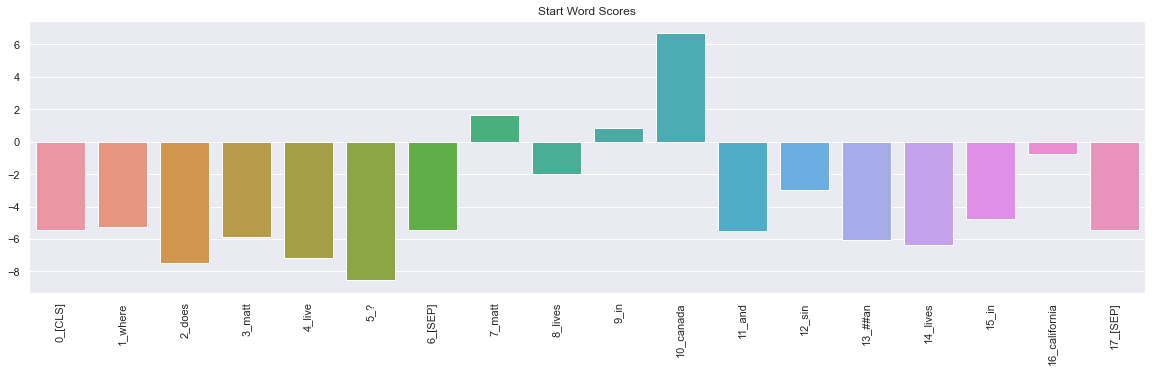

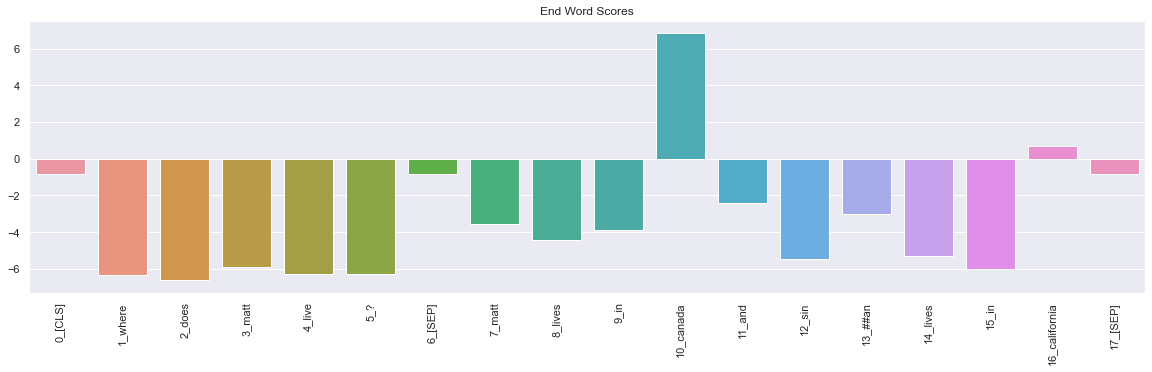

'canada'

In [51]:
q_a("Where does Matt live?", "Matt lives in Canada and Sinan lives in California")

In [52]:
# From https://docs.microsoft.com/en-us/azure/databricks/kb/jobs/active-vs-dead-jobs

longer_context = """
Whenever there are too many concurrent jobs running on a cluster, there is a chance that the Spark internal 
eventListenerBus drops events. These events are used to track job progress in the Spark UI. Whenever the event 
listener drops events you start seeing dead jobs/stages in Spark UI, which never finish. 
The jobs are actually finished but not shown as completed in the Spark UI.
"""

In [53]:
print(len(tokenizer(longer_context)['input_ids']))  # 78 tokens
      
for t in tokenizer(longer_context)['input_ids'][:30]:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')
    


78
Token: 101, subword: [CLS]
Token: 7188, subword: whenever
Token: 2045, subword: there
Token: 2024, subword: are
Token: 2205, subword: too
Token: 2116, subword: many
Token: 16483, subword: concurrent
Token: 5841, subword: jobs
Token: 2770, subword: running
Token: 2006, subword: on
Token: 1037, subword: a
Token: 9324, subword: cluster
Token: 1010, subword: ,
Token: 2045, subword: there
Token: 2003, subword: is
Token: 1037, subword: a
Token: 3382, subword: chance
Token: 2008, subword: that
Token: 1996, subword: the
Token: 12125, subword: spark
Token: 4722, subword: internal
Token: 2724, subword: event
Token: 9863, subword: ##list
Token: 24454, subword: ##ener
Token: 8286, subword: ##bus
Token: 9010, subword: drops
Token: 2824, subword: events
Token: 1012, subword: .
Token: 2122, subword: these
Token: 2824, subword: events


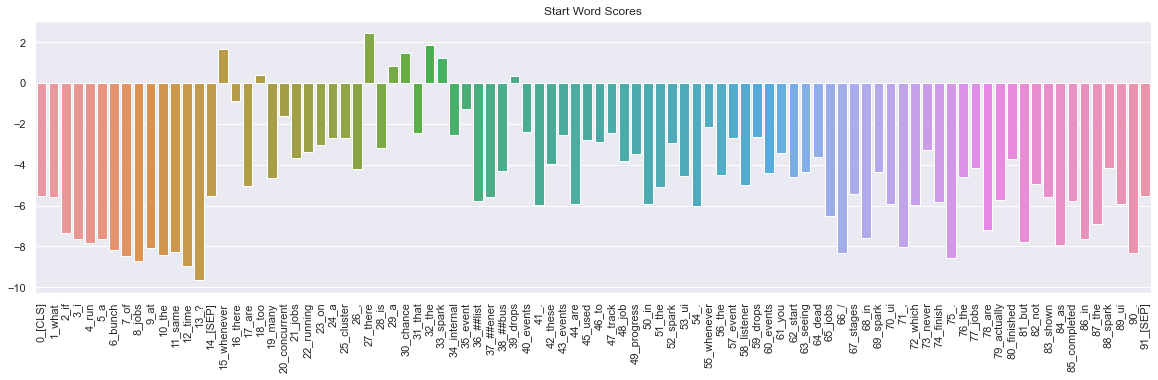

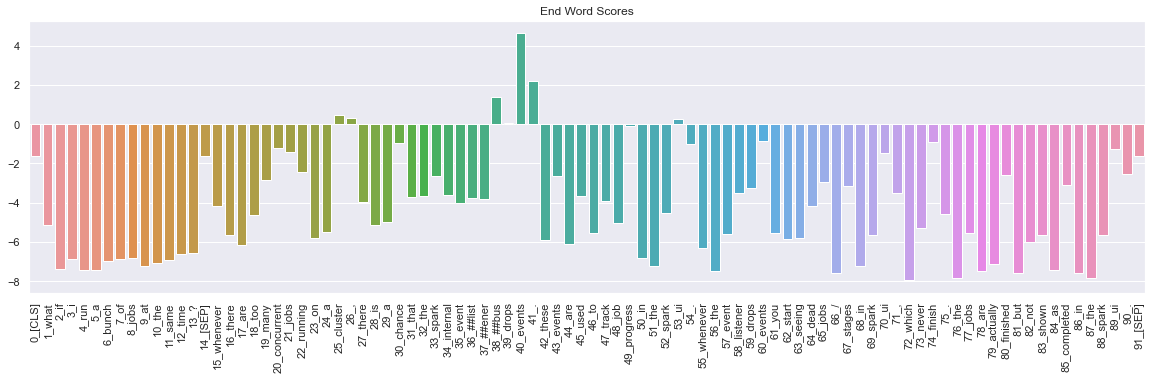

'there is a chance that the spark internal eventlistenerbus drops events'

In [54]:
q_a("what if I run a bunch of jobs at the same time?", longer_context)

# Working with flavors of BERT

In [55]:
distil_model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /Users/sinanozdemir/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851

In [ ]:
type(distil_model)

In [ ]:
# Get all of the model's parameters as a list of tuples.
named_params = list(distil_model.named_parameters())

print('The DistilBERT model has {:} different named parameters.\n'.format(len(named_params)))

print('==== Embedding Layer ====\n')
for p in named_params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in named_params[5:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


# Count the Parameters in DistilBERT

In [ ]:
total_params = 0
for p in distil_model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

![Transformers](images/hf_models.png)

In [ ]:
# https://huggingface.co/savasy/bert-base-turkish-ner-cased
custom_module = 'savasy/bert-base-turkish-ner-cased'

turkish_ner_tokenizer = AutoTokenizer.from_pretrained(custom_module)
turkish_ner_model = AutoModelForTokenClassification.from_pretrained(custom_module)

In [ ]:
type(turkish_ner_model.bert)  # standard BERT

In [ ]:
sequence = "Merhaba! Benim adım Sinan. San Francisco'dan geliyorum" # Hi! I'm Sinan. I come from San Francisco

In [ ]:
ner=pipeline('ner', model=turkish_ner_model, tokenizer=turkish_ner_tokenizer)
ner(sequence)